<a href="https://colab.research.google.com/github/Itsuki-Hamano123/auto_ml/blob/master/auto-keras/Beans/MobileNet_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install tensorflow-hub
%pip show tensorflow-hub
%pip show tensorflow

Name: tensorflow-hub
Version: 0.9.0
Summary: TensorFlow Hub is a library to foster the publication, discovery, and consumption of reusable parts of machine learning models.
Home-page: https://github.com/tensorflow/hub
Author: Google LLC
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: protobuf, six, numpy
Required-by: 
Name: tensorflow
Version: 2.3.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: termcolor, grpcio, google-pasta, protobuf, absl-py, astunparse, tensorboard, numpy, opt-einsum, wrapt, tensorflow-estimator, wheel, six, scipy, keras-preprocessing, gast, h5py
Required-by: fancyimpute


In [22]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import tensorflow_datasets  as tfds
import tensorflow_hub as hub

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## データの読み込み

In [3]:
def fetch_tf_dataset(data_name, 
                     split=['train','validation','test'],
                     shuffle_files=True, as_supervised=True,
                     with_info=True, batch_size=None):
  '''TensorFlowデータセットからデータをフェッチ'''
  (ds_train, ds_val, ds_test), data_info = tfds.load(data_name, split=split,
                                  shuffle_files=shuffle_files,
                                  as_supervised=as_supervised,
                                  with_info=with_info,
                                  batch_size=batch_size)
  return ds_train, ds_val, ds_test, data_info
  


data_name = 'beans' # @param{type:'string'}
x_name = 'image' # @param{type:'string'}
y_name = 'label' # @param{type:'string'}
# データのバッチサイズ
BATCH_SIZE = 256 # @param{type:'number'}

# データのフェッチ
ds_train, ds_val, ds_test, ds_info = fetch_tf_dataset(data_name=data_name,
                                     as_supervised=True,
                                     batch_size=BATCH_SIZE)

display(ds_info)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteOBW2MU/beans-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteOBW2MU/beans-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteOBW2MU/beans-test.tfrecord


Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='beans',
    version=0.1.0,
    description='Beans is a dataset of images of beans taken in the field using smartphone
cameras. It consists of 3 classes: 2 disease classes and the healthy class.
Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
by experts from the National Crops Resources Research Institute (NaCRRI) in
Uganda and collected by the Makerere AI research lab.
',
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=1295,
    splits={
        'test': 128,
        'train': 1034,
        'validation': 133,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {beansdata,
        author="Makerere AI Lab",
        title="Bean disease dataset",
        month="January",
        year="2020",
        url="https://gi

# モデル作成

## 前処理を行うKerasレイヤー
https://www.tensorflow.org/tutorials/images/data_augmentation?hl=ja

In [4]:
# リサイズ後の画像サイズ
RESIZE_IMG_SIZE = 224

# 画像のリサイズと、画素値のリスケールを行う層
resize_and_rescale = tf.keras.Sequential(layers=[
  layers.experimental.preprocessing.Resizing(height=RESIZE_IMG_SIZE,
                                             width=RESIZE_IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
], name='resize_and_rescale')


# Data Augmentationを行う層 
# 推論時には実行されない層
data_augmentation = tf.keras.Sequential(layers=[
                                          layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                          layers.experimental.preprocessing.RandomRotation(0.2),
                                        ], name='train_data_augmentation')

## ファインチューニングさせるMobileNet
前処理レイヤーの差し込みも行う

In [5]:
def _fetch_hub_keras_layer(hub_url, trainable=False):
  '''tensorflow hubのレイヤーをKerasレイヤーとしてfetch'''
  fetch_keras_layer = hub.KerasLayer(hub_url, trainable=trainable)
  return fetch_keras_layer


def clf_model_fn(hub_url, input_shape, output_shape, hub_layer_trainable=False):
  '''分類モデルの構造を定義'''
  model = Sequential([
                      resize_and_rescale, # 前処理用のレイヤー
                      data_augmentation, # 前処理用のレイヤー
                      _fetch_hub_keras_layer(hub_url, trainable=hub_layer_trainable),
                      layers.Dense(output_shape, activation='softmax')
  ])
  model.build(input_shape)
  return model


TF_HUB_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4' #@param{type:'string'}
# 画像をリサイズする層があるためinputの画像サイズは未指定
MODEL_INPUT_SHAPE = (None, None, None, 3)
CLASS_NUM = ds_info.features[y_name].num_classes
FINE_TUNING = False

clf = clf_model_fn(hub_url=TF_HUB_URL, input_shape=MODEL_INPUT_SHAPE,
                   output_shape=CLASS_NUM, hub_layer_trainable=FINE_TUNING)
clf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resize_and_rescale (Sequenti (None, 224, 224, 3)       0         
_________________________________________________________________
train_data_augmentation (Seq (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [6]:
es = EarlyStopping(patience=3)

clf.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(0.001),
    metrics=['accuracy'],
)

In [7]:
EPOCHS = 100 #@param{type:'number'}

# バッチサイズはDatasetをfetchする際に指定済み
clf.fit(ds_train, epochs=EPOCHS,
        validation_data=ds_val,
        callbacks=[es])

Epoch 1/100
5/5 [==============================] - 4s 706ms/step - loss: 1.1666 - accuracy: 0.4159 - val_loss: 1.0094 - val_accuracy: 0.5038
Epoch 2/100
5/5 [==============================] - 2s 472ms/step - loss: 0.8922 - accuracy: 0.6035 - val_loss: 0.8435 - val_accuracy: 0.6241
Epoch 3/100
5/5 [==============================] - 2s 474ms/step - loss: 0.7378 - accuracy: 0.7234 - val_loss: 0.6917 - val_accuracy: 0.7218
Epoch 4/100
5/5 [==============================] - 2s 454ms/step - loss: 0.6569 - accuracy: 0.7273 - val_loss: 0.6254 - val_accuracy: 0.7444
Epoch 5/100
5/5 [==============================] - 2s 473ms/step - loss: 0.5960 - accuracy: 0.7631 - val_loss: 0.5839 - val_accuracy: 0.7669
Epoch 6/100
5/5 [==============================] - 2s 469ms/step - loss: 0.5480 - accuracy: 0.7834 - val_loss: 0.5387 - val_accuracy: 0.8045
Epoch 7/100
5/5 [==============================] - 2s 459ms/step - loss: 0.5105 - accuracy: 0.8027 - val_loss: 0.5059 - val_accuracy: 0.8195
Epoch 8/100
5

# モデルの評価

In [20]:
%time
def take_y_from_tf_dataset(ds):
  '''tensorflow.datasetから正解ラベル取り出し'''
  ds_y = ds.map(map_func=lambda X,y:y) # ラベルのみを返す
  np_list_y  = list(ds_y.as_numpy_iterator())

  flat_y = np.empty(0, dtype='int')
  for np_array in np_list_y:
    # batch_size毎に分割されたラベルを一次元に結合
    flat_y = np.append(flat_y, np_array)
  return flat_y


# tensorflow Datasetから正解ラベルを取り出し
y_train = take_y_from_tf_dataset(ds_train)
y_val = take_y_from_tf_dataset(ds_val)
y_test = take_y_from_tf_dataset(ds_test)


# モデルの予測結果取得
pred_train = np.argmax(clf.predict(ds_train), axis=-1)
pred_val = np.argmax(clf.predict(ds_val), axis=-1)
pred_test = np.argmax(clf.predict(ds_test), axis=-1)

display(pred_train.shape, pred_val.shape, pred_test.shape)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


(1034,)

(133,)

(128,)

----- 訓練データ レポート-----


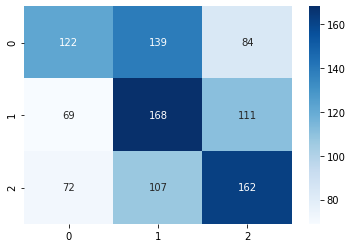

              precision    recall  f1-score   support

           0       0.46      0.35      0.40       345
           1       0.41      0.48      0.44       348
           2       0.45      0.48      0.46       341

    accuracy                           0.44      1034
   macro avg       0.44      0.44      0.44      1034
weighted avg       0.44      0.44      0.44      1034

----------
----- 検証データ レポート-----


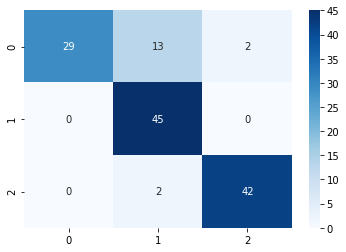

              precision    recall  f1-score   support

           0       1.00      0.66      0.79        44
           1       0.75      1.00      0.86        45
           2       0.95      0.95      0.95        44

    accuracy                           0.87       133
   macro avg       0.90      0.87      0.87       133
weighted avg       0.90      0.87      0.87       133

----------
----- テストデータ レポート-----


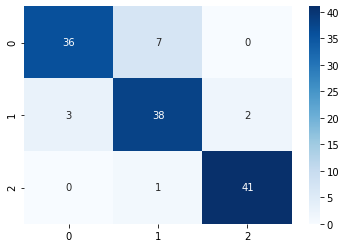

              precision    recall  f1-score   support

           0       0.92      0.84      0.88        43
           1       0.83      0.88      0.85        43
           2       0.95      0.98      0.96        42

    accuracy                           0.90       128
   macro avg       0.90      0.90      0.90       128
weighted avg       0.90      0.90      0.90       128

----------


In [23]:
def _calc_sk_metric(sk_metric, y_true, y_pred):
  '''sklearnの評価関数を使う'''
  result = sk_metric(y_true, y_pred)
  return result


def print_sk_metrics(sk_metrics, y_true, y_pred, data_name=None):
  '''sklearnの評価指標の計算結果を画面に出力'''
  print('----- {} レポート-----'.format(data_name))
  for sk_metric in sk_metrics:
    report = _calc_sk_metric(sk_metric, y_true, y_pred)
    
    if(sk_metric.__name__ == 'confusion_matrix'):
      plt.show(sns.heatmap(report, annot=True, fmt='d', cmap='Blues'))
    else:
      print(report)

  print('----------')


use_sk_metrics = [confusion_matrix, classification_report]


# 訓練データに対する評価
print_sk_metrics(sk_metrics=use_sk_metrics, y_true=y_train,
                 y_pred=pred_train, data_name='訓練データ')

# 検証データに対する評価
print_sk_metrics(sk_metrics=use_sk_metrics, y_true=y_val,
                 y_pred=pred_val, data_name='検証データ')

# テストデータに対する評価
print_sk_metrics(sk_metrics=use_sk_metrics, y_true=y_test,
                 y_pred=pred_test, data_name='テストデータ')